In [1]:
import re

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# Описание

[Датасет](https://www.kaggle.com/rajeevw/ufcdata) представляет собой полный список всех боёв **UFC**. Каждая строка содержит информацию об обоих бойцах, деталях боя и о том, кто победил. 

Весь датасет состоит из 4-х файлов:
* `data.csv` - список всех боёв UFC и информация о бое
* `raw_fighter_details.csv` - список всех бойцов UFC за эти годы и информация о них
* `preprocessed_data.csv` - обработанные данные, содержащие всю необходимую информацию для составления прогнозов
* `raw_total_fight_data.csv` - необработанные данные для того, чтобы можно было составить и обработать данные самим

При анализе и составлении модели будем ориентироваться на датасет `preprocessed_data.csv`.

Каждая строка содержит статистику обоих бойцов. Бойцы представлены `red` и `blue` углами. К примеру, в данных указана средняя статистика красного бойца по всем боям, кроме текущего. Столбец `Winner` указывает на победителя - целевая переменная. 

**Описание признаков**:

* `R_` и `B_` - префикс, указывающий на то, к какому бойцу относится статистика 
* `_opp_` - указывает но то, какой урон нанесен оппонентом бойца
* `KD` - число нокдаунов
* `SIG_STR` - число существенных ударов
* `SIG_STR_pct` - процент существенных ударов
* `TOTAL_STR` - всего ударов (достигших цели от общего числа нанесённых - landed of attempted)
* `TD` - число тейкдаунов
* `TD_pct` - процент тейкдаунов
* `SUB_ATT` - число попыток болевого приёма
* `PASS` - "times the guard was passed?"
* `REV` - is the no. of Reversals landed
* `HEAD` - число существенных ударов в голову
* `BODY` - число существенных ударов в тело
* `CLINCH` - число существенных ударов в клинче
* `GROUND` - число существеных ударов "на земле"
* `win_by` - чем получена победа
* `last_round` - последний раунд в бое (если нокаут в первом раунде, то это 1)
* `last_round_time` - время, когда бой закончился в последнем раунде
* `Format` - формат боя (3 раунда, 5 раундов и т.д.)
* `Referee` - имя судьи
* `date` - дата боя
* `location` - локация боя
* `Fight_type` - весовая категория и титульный ли это бой
* `Winner` - победитель боя
* `Stance` - позиция бойца
* `Height_cms` - высота в сантиметрах
* `Reach_cms` - длина рук в сантиметрах
* `Weight_lbs`  - вес в фунтах
* `age` - возраст бойца
* `title_bout` - титульный ли бой
* `weight_class` - весовая категория 
* `no_of_rounds` - количество раундов, на которое запланирован бой
* `current_lose_streak` - текущая проигрышная серия
* `current_win_streak` - текущая выигрышная серия
* `draw` - количество ничей в карьере
* `wins` - количество побед в карьере
* `losses` - количество проигрышей в карьере
* `total_rounds_fought` - среднее количество раундов
* `total_time_fought(seconds)` - общее количество времени в бое
* `total_title_bouts` - общее количество титульных боёв, в которых принято участие
* `win_by_Decision_Majority` - количество побед в карьере, полученных по решению большинства судей
* `win_by_Decision_Split` - количество побед в карьере, полученных по решению разеделенным мненением судей
* `win_by_Decision_Unanimous` - количество побед в карьере, полученных единогласным решением судей
* `win_by_KO/TKO` - количество побед нокаутом
* `win_by_Submission` - количество побед болевым приёмом
* `win_by_TKO_Doctor_Stoppage` - количество побед, полученных за счёт остановки боя доктором


Возникает объективная гипотеза о том, какие признаки действительно являются существенными в определении победителя: 
- возраст бойца
- длина рук
- рост
- вес
- каким стилем дерётся - ударник или борец
- опыт
- насколько боец техничнее своего оппонента

# Первичный EDA

## Готовый датасет

Чтобы выявить, какие признаки являются существенными, попробуем обучить случайный лес и убедиться. Важное правило: **мусор на входе - мусор на выходе**.

In [2]:
df = pd.read_csv('./preprocessed_data.csv')
df

,Winner,title_bout,B_avg_KD,B_avg_opp_KD,B_avg_SIG_STR_pct,B_avg_opp_SIG_STR_pct,B_avg_TD_pct,B_avg_opp_TD_pct,B_avg_SUB_ATT,B_avg_opp_SUB_ATT,...,B_Stance_Open Stance,B_Stance_Orthodox,B_Stance_Sideways,B_Stance_Southpaw,B_Stance_Switch,R_Stance_Open Stance,R_Stance_Orthodox,R_Stance_Sideways,R_Stance_Southpaw,R_Stance_Switch
0,Red,False,0.000000,0.0,0.420000,0.49500,0.330,0.36000,0.500000,1.000000,...,0,1,0,0,0,0,1,0,0,0
1,Red,False,0.500000,0.0,0.660000,0.30500,0.300,0.50000,1.500000,0.000000,...,0,1,0,0,0,0,1,0,0,0
2,Red,False,0.015625,0.0,0.450000,0.42750,0.250,0.20000,0.148468,0.098389,...,0,1,0,0,0,0,0,0,1,0
3,Blue,False,0.015625,0.0,0.450000,0.42750,0.250,0.20000,0.148468,0.098389,...,0,0,0,1,0,0,0,0,0,1
4,Blue,False,0.125000,0.0,0.535625,0.57875,0.185,0.16625,0.125000,0.187500,...,0,1,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5897,Red,False,0.015625,0.0,0.450000,0.42750,0.250,0.20000,0.148468,0.098389,...,0,1,0,0,0,0,0,0,1,0
5898,Red,False,0.015625,0.0,0.450000,0.42750,0.250,0.20000,0.148468,0.098389,...,0,1,0,0,0,0,0,0,1,0
5899,Red,False,0.015625,0.0,0.450000,0.42750,0.250,0.20000,0.148468,0.098389,...,0,1,0,0,0,0,1,0,0,0
5900,Red,False,0.015625,0.0,0.450000,0.42750,0.250,0.20000,0.148468,0.098389,...,0,1,0,0,0,0,1,0,0,0


Полный список признаков:

In [3]:
list(df.columns)

['Winner',
 'title_bout',
 'B_avg_KD',
 'B_avg_opp_KD',
 'B_avg_SIG_STR_pct',
 'B_avg_opp_SIG_STR_pct',
 'B_avg_TD_pct',
 'B_avg_opp_TD_pct',
 'B_avg_SUB_ATT',
 'B_avg_opp_SUB_ATT',
 'B_avg_REV',
 'B_avg_opp_REV',
 'B_avg_SIG_STR_att',
 'B_avg_SIG_STR_landed',
 'B_avg_opp_SIG_STR_att',
 'B_avg_opp_SIG_STR_landed',
 'B_avg_TOTAL_STR_att',
 'B_avg_TOTAL_STR_landed',
 'B_avg_opp_TOTAL_STR_att',
 'B_avg_opp_TOTAL_STR_landed',
 'B_avg_TD_att',
 'B_avg_TD_landed',
 'B_avg_opp_TD_att',
 'B_avg_opp_TD_landed',
 'B_avg_HEAD_att',
 'B_avg_HEAD_landed',
 'B_avg_opp_HEAD_att',
 'B_avg_opp_HEAD_landed',
 'B_avg_BODY_att',
 'B_avg_BODY_landed',
 'B_avg_opp_BODY_att',
 'B_avg_opp_BODY_landed',
 'B_avg_LEG_att',
 'B_avg_LEG_landed',
 'B_avg_opp_LEG_att',
 'B_avg_opp_LEG_landed',
 'B_avg_DISTANCE_att',
 'B_avg_DISTANCE_landed',
 'B_avg_opp_DISTANCE_att',
 'B_avg_opp_DISTANCE_landed',
 'B_avg_CLINCH_att',
 'B_avg_CLINCH_landed',
 'B_avg_opp_CLINCH_att',
 'B_avg_opp_CLINCH_landed',
 'B_avg_GROUND_att',
 

In [4]:
X = df.drop('Winner', axis=1)
y = df['Winner']

In [5]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

param_grid = [
    {"n_estimators": [100, 500],
     "criterion": ["gini"],
     "max_depth": [10],
     "min_samples_split": [2],
     "min_samples_leaf": [2]}
]

model = GridSearchCV(RandomForestClassifier(), param_grid, cv=5, n_jobs=-1, verbose=3, scoring='f1_weighted')

In [6]:
model.fit(X, y)

Fitting 5 folds for each of 2 candidates, totalling 10 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid=[{'criterion': ['gini'], 'max_depth': [10],
                          'min_samples_leaf': [2], 'min_samples_split': [2],
                          'n_estimators': [100, 500]}],
             scoring='f1_weighted', verbose=3)

In [7]:
model.best_score_

0.5928476647198905

In [8]:
forest = model.best_estimator_

for feature, importance in sorted(zip(df.drop('Winner', axis=1).columns, forest.feature_importances_), key=lambda x: x[1], reverse=True):
    print(feature, importance)

R_avg_opp_HEAD_landed 0.018359044317729604
R_age 0.017178257454032283
R_avg_opp_DISTANCE_landed 0.01697749917842351
R_avg_opp_SIG_STR_landed 0.01646568370171239
R_avg_opp_SIG_STR_pct 0.015952617847527148
B_avg_DISTANCE_landed 0.015916744736758175
B_avg_SIG_STR_att 0.01582844616097808
B_avg_HEAD_att 0.01318693832348507
B_avg_DISTANCE_att 0.01260033867408924
B_avg_HEAD_landed 0.01241819773666652
R_avg_GROUND_att 0.012181523324140435
B_avg_BODY_att 0.011980283436688357
R_avg_opp_BODY_att 0.011859539909807025
B_avg_SIG_STR_landed 0.011832800643077707
B_avg_opp_DISTANCE_landed 0.01144977341935353
R_avg_opp_CTRL_time(seconds) 0.011121655369921102
R_avg_opp_DISTANCE_att 0.010948785578174016
R_avg_opp_BODY_landed 0.010726628345195874
B_avg_opp_DISTANCE_att 0.01061776589263984
R_avg_GROUND_landed 0.010427863924327345
B_age 0.010363338786871054
R_total_time_fought(seconds) 0.010226050426062817
B_avg_TD_att 0.010039110514290898
B_avg_BODY_landed 0.00996349302986303
R_avg_TD_pct 0.0098339408738901

Модель случайного леса является лишь немного лучше случайного классификатора, поэтому гарантировать, что она даёт правильную важность признаков так же не стоит. Однако, из списка важных признаков можно заметить вполне логичные вещи:
- весовая категория бойцов
- количество ничей
- количество побед
- позиция (stance)  

не являются информативными, а значит, что следовало бы от них избавиться.

In [9]:
exclude_features = ['Stance', 'draw', 'weight_class']
exclude_features_names = []

for feature in df.drop('Winner', axis=1).columns:
    if re.search(fr'(_|\b)({"|".join(exclude_features)})(_|\b)', feature, re.IGNORECASE):
        exclude_features_names.append(feature)

In [10]:
exclude_features_names

['B_draw',
 'R_draw',
 'weight_class_Bantamweight',
 'weight_class_CatchWeight',
 'weight_class_Featherweight',
 'weight_class_Flyweight',
 'weight_class_Heavyweight',
 'weight_class_LightHeavyweight',
 'weight_class_Lightweight',
 'weight_class_Middleweight',
 'weight_class_OpenWeight',
 'weight_class_Welterweight',
 'weight_class_WomenBantamweight',
 'weight_class_WomenFeatherweight',
 'weight_class_WomenFlyweight',
 'weight_class_WomenStrawweight',
 'B_Stance_Open Stance',
 'B_Stance_Orthodox',
 'B_Stance_Sideways',
 'B_Stance_Southpaw',
 'B_Stance_Switch',
 'R_Stance_Open Stance',
 'R_Stance_Orthodox',
 'R_Stance_Sideways',
 'R_Stance_Southpaw',
 'R_Stance_Switch']

In [11]:
X.drop(exclude_features_names, axis=1)

,title_bout,B_avg_KD,B_avg_opp_KD,B_avg_SIG_STR_pct,B_avg_opp_SIG_STR_pct,B_avg_TD_pct,B_avg_opp_TD_pct,B_avg_SUB_ATT,B_avg_opp_SUB_ATT,B_avg_REV,...,R_win_by_Decision_Split,R_win_by_Decision_Unanimous,R_win_by_KO/TKO,R_win_by_Submission,R_win_by_TKO_Doctor_Stoppage,R_Height_cms,R_Reach_cms,R_Weight_lbs,B_age,R_age
0,False,0.000000,0.0,0.420000,0.49500,0.330,0.36000,0.500000,1.000000,0.00,...,0,0,1,0,0,170.18,177.80,135.0,31.0,27.0
1,False,0.500000,0.0,0.660000,0.30500,0.300,0.50000,1.500000,0.000000,0.00,...,1,0,3,0,0,182.88,187.96,185.0,32.0,28.0
2,False,0.015625,0.0,0.450000,0.42750,0.250,0.20000,0.148468,0.098389,0.00,...,0,1,3,0,0,187.96,190.50,264.0,32.0,28.0
3,False,0.015625,0.0,0.450000,0.42750,0.250,0.20000,0.148468,0.098389,0.00,...,0,0,0,0,0,160.02,160.02,115.0,28.0,25.0
4,False,0.125000,0.0,0.535625,0.57875,0.185,0.16625,0.125000,0.187500,0.25,...,0,1,2,2,0,167.64,172.72,135.0,29.0,43.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5897,False,0.015625,0.0,0.450000,0.42750,0.250,0.20000,0.148468,0.098389,0.00,...,0,0,0,0,0,190.50,190.50,260.0,29.0,29.0
5898,False,0.015625,0.0,0.450000,0.42750,0.250,0.20000,0.148468,0.098389,0.00,...,0,0,0,0,0,177.80,177.80,170.0,29.0,29.0
5899,False,0.015625,0.0,0.450000,0.42750,0.250,0.20000,0.148468,0.098389,0.00,...,0,0,0,0,0,182.88,182.88,210.0,29.0,29.0
5900,False,0.015625,0.0,0.450000,0.42750,0.250,0.20000,0.148468,0.098389,0.00,...,0,0,0,0,0,187.96,187.96,225.0,29.0,30.0


Обучим модель на новых данных

In [12]:
model = GridSearchCV(RandomForestClassifier(), param_grid, cv=5, n_jobs=-1, verbose=3, scoring='f1_weighted')
model.fit(X.drop(exclude_features_names, axis=1), y)

Fitting 5 folds for each of 2 candidates, totalling 10 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid=[{'criterion': ['gini'], 'max_depth': [10],
                          'min_samples_leaf': [2], 'min_samples_split': [2],
                          'n_estimators': [100, 500]}],
             scoring='f1_weighted', verbose=3)

Точность увеличилась, но не сильно

In [13]:
model.best_score_

0.5931130345873797

In [14]:
model.best_params_

{'criterion': 'gini',
 'max_depth': 10,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 100}

In [15]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [16]:
forest = RandomForestClassifier(**model.best_params_)
forest.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, min_samples_leaf=2)

In [17]:
from sklearn.metrics import classification_report, f1_score

In [18]:
print(classification_report(y_test, forest.predict(X_test)))

              precision    recall  f1-score   support

        Blue       0.58      0.10      0.17       384
         Red       0.69      0.96      0.80       797

    accuracy                           0.68      1181
   macro avg       0.63      0.53      0.49      1181
weighted avg       0.65      0.68      0.60      1181



In [19]:
f1_score(y_test, forest.predict(X_test), average='micro')

0.6833192209991532

Указанные показатели говорят о том, что по метрике F1 классификатор сильно ошибается в случае метки `Blue`, в то время как с меткой `Red` у него всё прекрасно.

## Сырой датасет

Давайте поработаем с сырым датасетом, чтобы вычленить необходимую статистику и понять, как лучше выстраивать конвейер обработки.

In [20]:
raw_data = pd.read_csv('raw_total_fight_data.csv', delimiter=';')
raw_data

,R_fighter,B_fighter,R_KD,B_KD,R_SIG_STR.,B_SIG_STR.,R_SIG_STR_pct,B_SIG_STR_pct,R_TOTAL_STR.,B_TOTAL_STR.,...,B_GROUND,win_by,last_round,last_round_time,Format,Referee,date,location,Fight_type,Winner
0,Adrian Yanez,Gustavo Lopez,2,0,41 of 103,23 of 51,39%,45%,41 of 103,23 of 51,...,0 of 0,KO/TKO,3,0:27,3 Rnd (5-5-5),Chris Tognoni,"March 20, 2021","Las Vegas, Nevada, USA",Bantamweight Bout,Adrian Yanez
1,Trevin Giles,Roman Dolidze,0,0,27 of 57,32 of 67,47%,47%,43 of 73,75 of 110,...,1 of 2,Decision - Unanimous,3,5:00,3 Rnd (5-5-5),Herb Dean,"March 20, 2021","Las Vegas, Nevada, USA",Middleweight Bout,Trevin Giles
2,Tai Tuivasa,Harry Hunsucker,1,0,14 of 18,2 of 6,77%,33%,14 of 18,2 of 6,...,0 of 0,KO/TKO,1,0:49,3 Rnd (5-5-5),Herb Dean,"March 20, 2021","Las Vegas, Nevada, USA",Heavyweight Bout,Tai Tuivasa
3,Cheyanne Buys,Montserrat Conejo,0,0,31 of 65,15 of 41,47%,36%,49 of 87,136 of 168,...,0 of 0,Decision - Unanimous,3,5:00,3 Rnd (5-5-5),Mark Smith,"March 20, 2021","Las Vegas, Nevada, USA",Women's Strawweight Bout,Montserrat Conejo
4,Marion Reneau,Macy Chiasson,0,0,30 of 63,51 of 138,47%,36%,59 of 93,92 of 184,...,2 of 4,Decision - Unanimous,3,5:00,3 Rnd (5-5-5),Mark Smith,"March 20, 2021","Las Vegas, Nevada, USA",Women's Bantamweight Bout,Macy Chiasson
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6007,Remco Pardoel,Alberta Cerra Leon,0,0,4 of 6,1 of 3,66%,33%,20 of 22,9 of 11,...,0 of 2,Submission,1,9:51,No Time Limit,John McCarthy,"March 11, 1994","Denver, Colorado, USA",Open Weight Bout,Remco Pardoel
6008,Orlando Wiet,Robert Lucarelli,0,0,8 of 12,2 of 6,66%,33%,11 of 15,2 of 6,...,0 of 0,KO/TKO,1,2:50,No Time Limit,John McCarthy,"March 11, 1994","Denver, Colorado, USA",Open Weight Bout,Orlando Wiet
6009,Johnny Rhodes,David Levicki,0,0,11 of 17,4 of 5,64%,80%,74 of 86,95 of 102,...,1 of 1,KO/TKO,1,12:13,No Time Limit,John McCarthy,"March 11, 1994","Denver, Colorado, USA",Open Weight Bout,Johnny Rhodes
6010,Patrick Smith,Ray Wizard,0,0,1 of 1,1 of 1,100%,100%,1 of 1,2 of 2,...,0 of 0,Submission,1,0:58,No Time Limit,John McCarthy,"March 11, 1994","Denver, Colorado, USA",Open Weight Bout,Patrick Smith


In [21]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6012 entries, 0 to 6011
Data columns (total 41 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   R_fighter        6012 non-null   object
 1   B_fighter        6012 non-null   object
 2   R_KD             6012 non-null   int64 
 3   B_KD             6012 non-null   int64 
 4   R_SIG_STR.       6012 non-null   object
 5   B_SIG_STR.       6012 non-null   object
 6   R_SIG_STR_pct    6012 non-null   object
 7   B_SIG_STR_pct    6012 non-null   object
 8   R_TOTAL_STR.     6012 non-null   object
 9   B_TOTAL_STR.     6012 non-null   object
 10  R_TD             6012 non-null   object
 11  B_TD             6012 non-null   object
 12  R_TD_pct         6012 non-null   object
 13  B_TD_pct         6012 non-null   object
 14  R_SUB_ATT        6012 non-null   int64 
 15  B_SUB_ATT        6012 non-null   int64 
 16  R_REV            6012 non-null   int64 
 17  B_REV            6012 non-null   

Можно заметить, что есть пустые значения в поле `Winner` и `Referee`. Если с `Referee` мы можем смириться, так как нам оно особо то и не надо (хотя может и не факт), то с полем `Winner` придется провести маленькую работу.

In [22]:
indexes_not_null = raw_data['Winner'].dropna().index
raw_data = raw_data.loc[indexes_not_null, :]
raw_data

,R_fighter,B_fighter,R_KD,B_KD,R_SIG_STR.,B_SIG_STR.,R_SIG_STR_pct,B_SIG_STR_pct,R_TOTAL_STR.,B_TOTAL_STR.,...,B_GROUND,win_by,last_round,last_round_time,Format,Referee,date,location,Fight_type,Winner
0,Adrian Yanez,Gustavo Lopez,2,0,41 of 103,23 of 51,39%,45%,41 of 103,23 of 51,...,0 of 0,KO/TKO,3,0:27,3 Rnd (5-5-5),Chris Tognoni,"March 20, 2021","Las Vegas, Nevada, USA",Bantamweight Bout,Adrian Yanez
1,Trevin Giles,Roman Dolidze,0,0,27 of 57,32 of 67,47%,47%,43 of 73,75 of 110,...,1 of 2,Decision - Unanimous,3,5:00,3 Rnd (5-5-5),Herb Dean,"March 20, 2021","Las Vegas, Nevada, USA",Middleweight Bout,Trevin Giles
2,Tai Tuivasa,Harry Hunsucker,1,0,14 of 18,2 of 6,77%,33%,14 of 18,2 of 6,...,0 of 0,KO/TKO,1,0:49,3 Rnd (5-5-5),Herb Dean,"March 20, 2021","Las Vegas, Nevada, USA",Heavyweight Bout,Tai Tuivasa
3,Cheyanne Buys,Montserrat Conejo,0,0,31 of 65,15 of 41,47%,36%,49 of 87,136 of 168,...,0 of 0,Decision - Unanimous,3,5:00,3 Rnd (5-5-5),Mark Smith,"March 20, 2021","Las Vegas, Nevada, USA",Women's Strawweight Bout,Montserrat Conejo
4,Marion Reneau,Macy Chiasson,0,0,30 of 63,51 of 138,47%,36%,59 of 93,92 of 184,...,2 of 4,Decision - Unanimous,3,5:00,3 Rnd (5-5-5),Mark Smith,"March 20, 2021","Las Vegas, Nevada, USA",Women's Bantamweight Bout,Macy Chiasson
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6007,Remco Pardoel,Alberta Cerra Leon,0,0,4 of 6,1 of 3,66%,33%,20 of 22,9 of 11,...,0 of 2,Submission,1,9:51,No Time Limit,John McCarthy,"March 11, 1994","Denver, Colorado, USA",Open Weight Bout,Remco Pardoel
6008,Orlando Wiet,Robert Lucarelli,0,0,8 of 12,2 of 6,66%,33%,11 of 15,2 of 6,...,0 of 0,KO/TKO,1,2:50,No Time Limit,John McCarthy,"March 11, 1994","Denver, Colorado, USA",Open Weight Bout,Orlando Wiet
6009,Johnny Rhodes,David Levicki,0,0,11 of 17,4 of 5,64%,80%,74 of 86,95 of 102,...,1 of 1,KO/TKO,1,12:13,No Time Limit,John McCarthy,"March 11, 1994","Denver, Colorado, USA",Open Weight Bout,Johnny Rhodes
6010,Patrick Smith,Ray Wizard,0,0,1 of 1,1 of 1,100%,100%,1 of 1,2 of 2,...,0 of 0,Submission,1,0:58,No Time Limit,John McCarthy,"March 11, 1994","Denver, Colorado, USA",Open Weight Bout,Patrick Smith


In [23]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5902 entries, 0 to 6011
Data columns (total 41 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   R_fighter        5902 non-null   object
 1   B_fighter        5902 non-null   object
 2   R_KD             5902 non-null   int64 
 3   B_KD             5902 non-null   int64 
 4   R_SIG_STR.       5902 non-null   object
 5   B_SIG_STR.       5902 non-null   object
 6   R_SIG_STR_pct    5902 non-null   object
 7   B_SIG_STR_pct    5902 non-null   object
 8   R_TOTAL_STR.     5902 non-null   object
 9   B_TOTAL_STR.     5902 non-null   object
 10  R_TD             5902 non-null   object
 11  B_TD             5902 non-null   object
 12  R_TD_pct         5902 non-null   object
 13  B_TD_pct         5902 non-null   object
 14  R_SUB_ATT        5902 non-null   int64 
 15  B_SUB_ATT        5902 non-null   int64 
 16  R_REV            5902 non-null   int64 
 17  B_REV            5902 non-null   

Давайте посмотрим в каких странах часто проводились бои.

In [24]:
countries = raw_data['location'].apply(lambda x: x.split(',')[-1].strip())
countries

0       USA
1       USA
2       USA
3       USA
4       USA
       ... 
6007    USA
6008    USA
6009    USA
6010    USA
6011    USA
Name: location, Length: 5902, dtype: object

In [25]:
raw_data['country'] = countries
raw_data

,R_fighter,B_fighter,R_KD,B_KD,R_SIG_STR.,B_SIG_STR.,R_SIG_STR_pct,B_SIG_STR_pct,R_TOTAL_STR.,B_TOTAL_STR.,...,win_by,last_round,last_round_time,Format,Referee,date,location,Fight_type,Winner,country
0,Adrian Yanez,Gustavo Lopez,2,0,41 of 103,23 of 51,39%,45%,41 of 103,23 of 51,...,KO/TKO,3,0:27,3 Rnd (5-5-5),Chris Tognoni,"March 20, 2021","Las Vegas, Nevada, USA",Bantamweight Bout,Adrian Yanez,USA
1,Trevin Giles,Roman Dolidze,0,0,27 of 57,32 of 67,47%,47%,43 of 73,75 of 110,...,Decision - Unanimous,3,5:00,3 Rnd (5-5-5),Herb Dean,"March 20, 2021","Las Vegas, Nevada, USA",Middleweight Bout,Trevin Giles,USA
2,Tai Tuivasa,Harry Hunsucker,1,0,14 of 18,2 of 6,77%,33%,14 of 18,2 of 6,...,KO/TKO,1,0:49,3 Rnd (5-5-5),Herb Dean,"March 20, 2021","Las Vegas, Nevada, USA",Heavyweight Bout,Tai Tuivasa,USA
3,Cheyanne Buys,Montserrat Conejo,0,0,31 of 65,15 of 41,47%,36%,49 of 87,136 of 168,...,Decision - Unanimous,3,5:00,3 Rnd (5-5-5),Mark Smith,"March 20, 2021","Las Vegas, Nevada, USA",Women's Strawweight Bout,Montserrat Conejo,USA
4,Marion Reneau,Macy Chiasson,0,0,30 of 63,51 of 138,47%,36%,59 of 93,92 of 184,...,Decision - Unanimous,3,5:00,3 Rnd (5-5-5),Mark Smith,"March 20, 2021","Las Vegas, Nevada, USA",Women's Bantamweight Bout,Macy Chiasson,USA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6007,Remco Pardoel,Alberta Cerra Leon,0,0,4 of 6,1 of 3,66%,33%,20 of 22,9 of 11,...,Submission,1,9:51,No Time Limit,John McCarthy,"March 11, 1994","Denver, Colorado, USA",Open Weight Bout,Remco Pardoel,USA
6008,Orlando Wiet,Robert Lucarelli,0,0,8 of 12,2 of 6,66%,33%,11 of 15,2 of 6,...,KO/TKO,1,2:50,No Time Limit,John McCarthy,"March 11, 1994","Denver, Colorado, USA",Open Weight Bout,Orlando Wiet,USA
6009,Johnny Rhodes,David Levicki,0,0,11 of 17,4 of 5,64%,80%,74 of 86,95 of 102,...,KO/TKO,1,12:13,No Time Limit,John McCarthy,"March 11, 1994","Denver, Colorado, USA",Open Weight Bout,Johnny Rhodes,USA
6010,Patrick Smith,Ray Wizard,0,0,1 of 1,1 of 1,100%,100%,1 of 1,2 of 2,...,Submission,1,0:58,No Time Limit,John McCarthy,"March 11, 1994","Denver, Colorado, USA",Open Weight Bout,Patrick Smith,USA


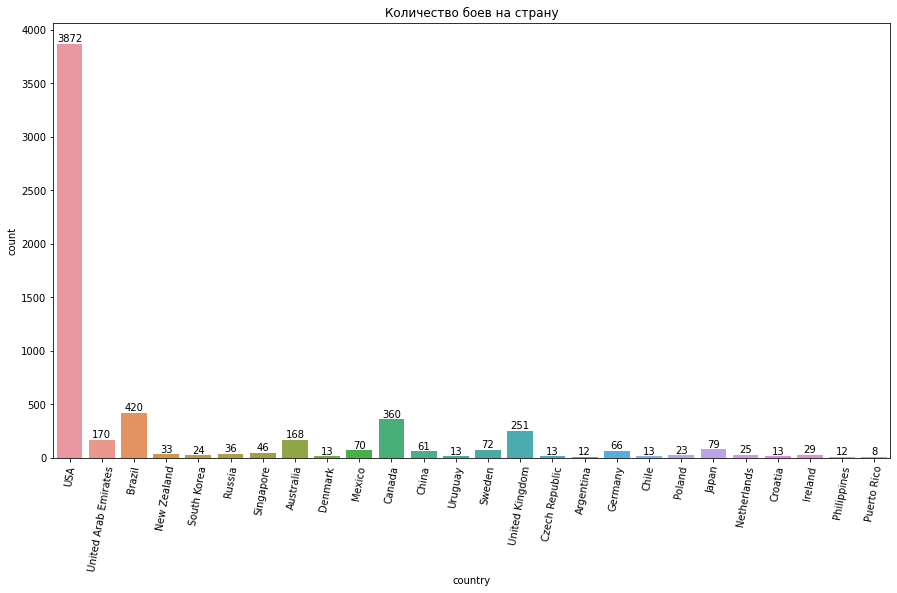

In [26]:
plt.figure(figsize=(15,8))
bar = sns.countplot(x=raw_data['country'])
plt.xticks(rotation=80)
ax = plt.gca()
for p in ax.patches:
    ax.text(p.get_x() + p.get_width()/2., p.get_height(), p.get_height(), 
        fontsize=10, color='black', ha='center', va='bottom')

plt.title('Количество боев на страну')    
plt.show()

Благодаря такому распределению стран можно понять стоит ли проверять гипотезу о том, что страна проведения боя может играть роль в конечном результате боя.

In [27]:
def get_color_winner(x):
    if x['R_fighter'] == x['Winner']:
        return 'Red'
    elif x['B_fighter'] == x['Winner']:
        return 'Blue'
    return x

raw_data['Winner'] = raw_data[['R_fighter', 'B_fighter', 'Winner']].apply(get_color_winner, axis=1)

In [28]:
raw_data['Winner'].value_counts()

Red     3979
Blue    1923
Name: Winner, dtype: int64

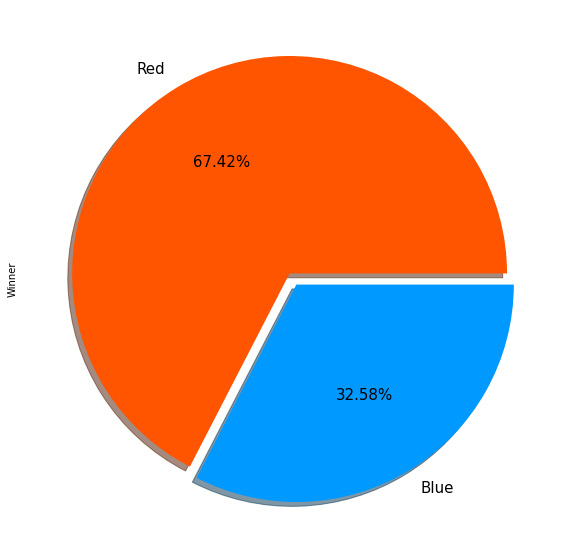

In [29]:
from matplotlib.colors import ListedColormap

raw_data['Winner'].value_counts().plot.pie(explode=[0.03, 0.03], autopct='%1.2f%%', shadow=True, 
                                           figsize=(10, 10), fontsize=15, 
                                           colormap=ListedColormap(['#ff5500', '#0099ff']))
plt.show()

Как можно понять из графика красный угол выигрывает примерно в два раза чаще, чем синий. Это сходится с той логикой, что в красный угол выставляют фаворита матча.

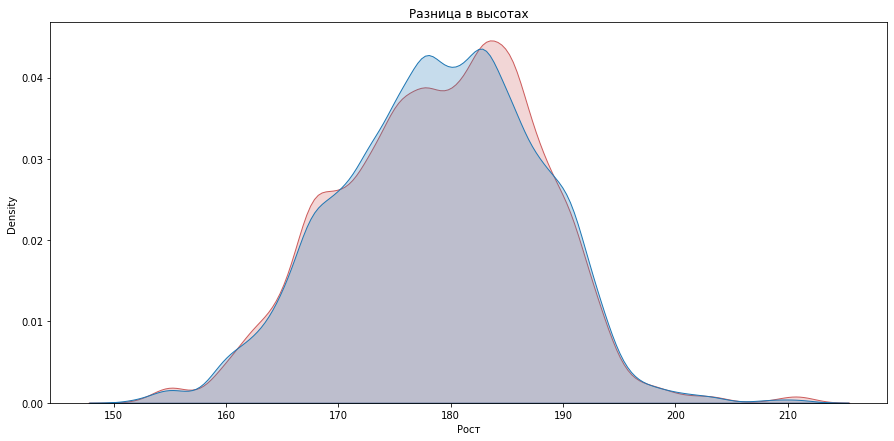

In [30]:
plt.figure(figsize=(15, 7))
sns.kdeplot(df['R_Height_cms'], shade=True, color='indianred', label='Red')
sns.kdeplot(df['B_Height_cms'], shade=True, label='Blue')
plt.xlabel('Рост')
plt.title('Разница в высотах')

plt.show()

Как можно видеть, рост красного угла выше, чем синего, что так же может являться признаком того, что красный угол побеждает чаще.

Давайте рассмотрим каким методом чаще всего выигрывают бои, чтобы понимать, как с этим можно взаимодействовать и насколько признак является существенным.

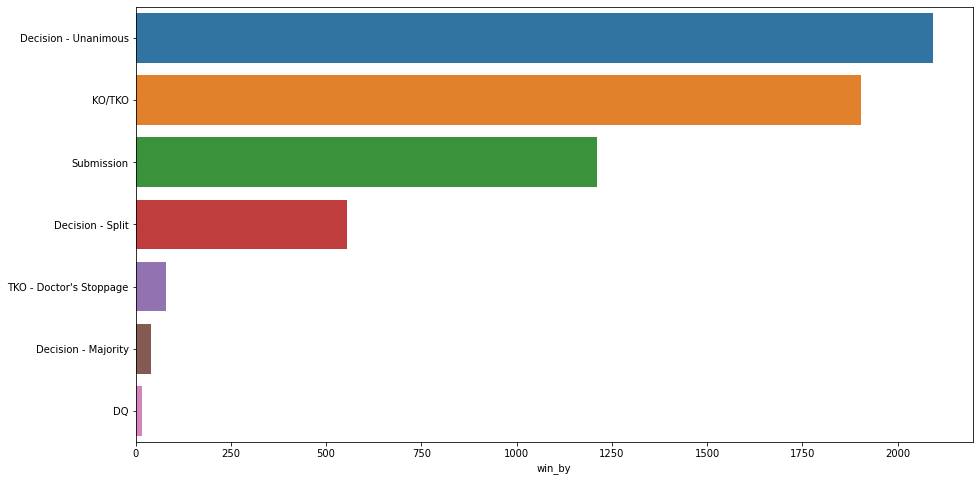

In [31]:
plt.figure(figsize=(15, 8))
sns.barplot(x=raw_data['win_by'].value_counts(), y=raw_data['win_by'].value_counts().index)
plt.show()

# Решение

Напишем функцию, которая будет создать тренировочный, тестовый и валидационный датасеты.

In [145]:
def train_val_test_split(X, y, test_size=0.2, val=True):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    if val:
        X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=test_size)
        return ((X_train, y_train), (X_val, y_val), (X_test, y_test))
    
    return (X_train, y_train), (X_test, y_test)

In [146]:
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

In [147]:
(X_train, y_train), (X_val, y_val), (X_test, y_test) = train_val_test_split(X, y)

In [148]:
encoder = LabelEncoder()
encoder.fit(y)

LabelEncoder()

In [149]:
scaler = StandardScaler()
scaler.fit(X_train)

StandardScaler()

In [150]:
xgb = XGBClassifier(use_label_encoder=False)
xgb.fit(scaler.transform(X_train), encoder.transform(y_train),
        eval_set=[(scaler.transform(X_val), encoder.transform(y_val))], 
        early_stopping_rounds=2)

[02:03:23] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-logloss:0.64775
[1]	validation_0-logloss:0.62588
[2]	validation_0-logloss:0.61413
[3]	validation_0-logloss:0.61052
[4]	validation_0-logloss:0.60674
[5]	validation_0-logloss:0.60188
[6]	validation_0-logloss:0.59815
[7]	validation_0-logloss:0.59537
[8]	validation_0-logloss:0.59883


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [151]:
print(classification_report(encoder.transform(y_test), xgb.predict(scaler.transform(X_test))))

              precision    recall  f1-score   support

           0       0.46      0.20      0.28       396
           1       0.69      0.88      0.77       785

    accuracy                           0.65      1181
   macro avg       0.57      0.54      0.53      1181
weighted avg       0.61      0.65      0.61      1181



Как можно заметить, модель XGBoost работает куда лучше, чем обычный случайный лес. Далее будем улучшать признаки, очищать данные и в конце пробовать использовать различные ансамбли.

# Полный EDA

В подготовленном датасете всё ок - без нулевых значений

In [41]:
df.isna().sum().sum()

0

## Весовые категории

Давайте проверим сколько боёв в какой категории больше всего проведено и какие соответствующие значения различных характеристик соответствуют этим весовым категориям. Это позволит понять - стоит ли рассматривать каждую категорию в отдельности.

In [47]:
weight_classes = ['weight_class_Bantamweight',
                  'weight_class_CatchWeight',
                  'weight_class_Featherweight',
                  'weight_class_Flyweight',
                  'weight_class_Heavyweight',
                  'weight_class_LightHeavyweight',
                  'weight_class_Lightweight',
                  'weight_class_Middleweight',
                  'weight_class_OpenWeight',
                  'weight_class_Welterweight',
                  'weight_class_WomenBantamweight',
                  'weight_class_WomenFeatherweight',
                  'weight_class_WomenFlyweight',
                  'weight_class_WomenStrawweight']

In [60]:
weigts = df[weight_classes].sum().sort_values(ascending=False)
weigts

weight_class_Lightweight           1072
weight_class_Welterweight          1066
weight_class_Middleweight           803
weight_class_Heavyweight            573
weight_class_LightHeavyweight       559
weight_class_Featherweight          539
weight_class_Bantamweight           462
weight_class_Flyweight              226
weight_class_WomenStrawweight       190
weight_class_WomenBantamweight      149
weight_class_WomenFlyweight         110
weight_class_OpenWeight              86
weight_class_CatchWeight             51
weight_class_WomenFeatherweight      16
dtype: int64

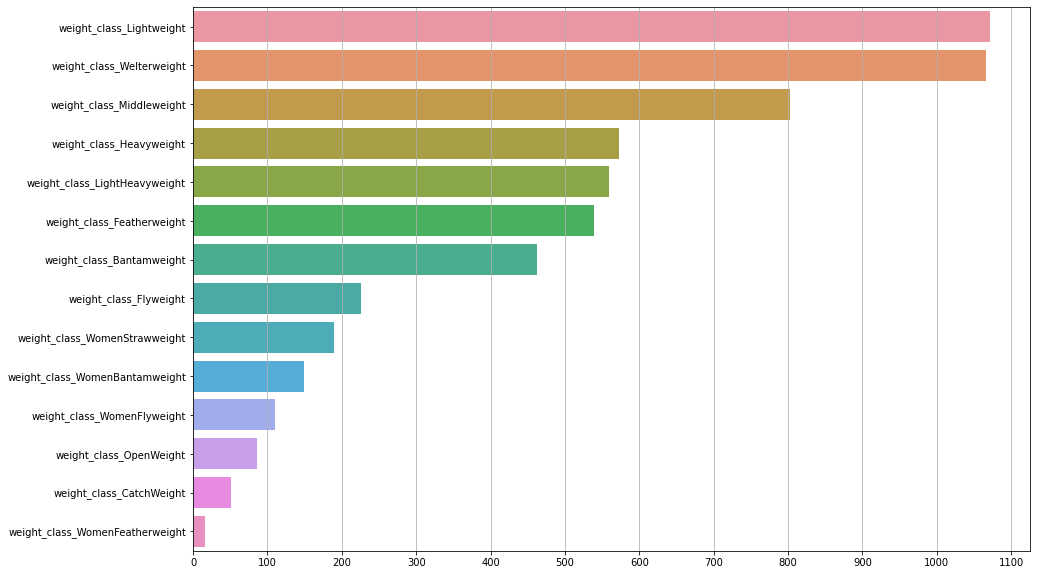

In [71]:
plt.figure(figsize=(15, 10))
plt.grid()
sns.barplot(x=weigts, y=weigts.index)
plt.xticks(range(0, 1101, 100))
plt.show()

## Lightweight

In [115]:
df_Lightweight = df[df['weight_class_Lightweight'] == 1]
df_Lightweight

,Winner,title_bout,B_avg_KD,B_avg_opp_KD,B_avg_SIG_STR_pct,B_avg_opp_SIG_STR_pct,B_avg_TD_pct,B_avg_opp_TD_pct,B_avg_SUB_ATT,B_avg_opp_SUB_ATT,...,B_Stance_Open Stance,B_Stance_Orthodox,B_Stance_Sideways,B_Stance_Southpaw,B_Stance_Switch,R_Stance_Open Stance,R_Stance_Orthodox,R_Stance_Sideways,R_Stance_Southpaw,R_Stance_Switch
5,Blue,False,0.000000,0.000,0.51500,0.473750,0.435000,0.250000,1.250000,0.625000,...,0,0,0,0,1,0,1,0,0,0
16,Red,False,0.015625,0.000,0.45000,0.427500,0.250000,0.200000,0.148468,0.098389,...,0,1,0,0,0,0,0,0,1,0
28,Red,False,0.388672,0.000,0.46942,0.420960,0.031592,0.341158,0.000122,0.098389,...,0,0,0,1,0,0,0,0,1,0
32,Red,False,0.000000,0.000,0.16000,0.680000,0.000000,0.000000,0.000000,0.000000,...,0,0,0,0,1,0,0,0,1,0
38,Blue,False,0.000000,0.125,0.30000,0.459375,0.371250,0.381875,1.062500,0.125000,...,0,1,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5795,Red,False,0.015625,0.000,0.45000,0.427500,0.250000,0.200000,0.148468,0.098389,...,0,1,0,0,0,0,1,0,0,0
5797,Red,False,0.015625,0.000,0.45000,0.427500,0.250000,0.200000,0.148468,0.098389,...,0,1,0,0,0,0,1,0,0,0
5800,Red,False,0.015625,0.000,0.45000,0.427500,0.250000,0.200000,0.148468,0.098389,...,0,1,0,0,0,0,1,0,0,0
5803,Red,False,0.015625,0.000,0.45000,0.427500,0.250000,0.200000,0.148468,0.098389,...,0,1,0,0,0,0,1,0,0,0


In [131]:
X_Lightweight = df_Lightweight.drop('Winner', axis=1)
y_Lightweight = df_Lightweight['Winner']

(X_train, y_train), (X_val, y_val), (X_test, y_test) = train_val_test_split(X_Lightweight, y_Lightweight)

In [132]:
scaler = StandardScaler()
scaler.fit(X_train)

StandardScaler()

In [134]:
xgb = XGBClassifier(use_label_encoder=False)
xgb.fit(scaler.transform(X_train), encoder.transform(y_train),
        eval_set=[(scaler.transform(X_val), encoder.transform(y_val))], 
        early_stopping_rounds=2)

[01:58:08] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-logloss:0.67032
[1]	validation_0-logloss:0.66847
[2]	validation_0-logloss:0.66385
[3]	validation_0-logloss:0.65871
[4]	validation_0-logloss:0.66305
[5]	validation_0-logloss:0.65619
[6]	validation_0-logloss:0.66127


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [135]:
print(classification_report(encoder.transform(y_test), xgb.predict(scaler.transform(X_test))))

              precision    recall  f1-score   support

           0       0.40      0.25      0.31        63
           1       0.73      0.84      0.78       152

    accuracy                           0.67       215
   macro avg       0.57      0.55      0.55       215
weighted avg       0.63      0.67      0.64       215



Получается, что классификатор, который предсказывает результаты для одной категории `Lightweight` не менее точный, чем классификатор, который работает со всеми данными. Вполне резонно проверить это для каждой категории.

## Welterweight

In [158]:
df_Welterweight = df[df['weight_class_Welterweight'] == 1]
df_Welterweight

,Winner,title_bout,B_avg_KD,B_avg_opp_KD,B_avg_SIG_STR_pct,B_avg_opp_SIG_STR_pct,B_avg_TD_pct,B_avg_opp_TD_pct,B_avg_SUB_ATT,B_avg_opp_SUB_ATT,...,B_Stance_Open Stance,B_Stance_Orthodox,B_Stance_Sideways,B_Stance_Southpaw,B_Stance_Switch,R_Stance_Open Stance,R_Stance_Orthodox,R_Stance_Sideways,R_Stance_Southpaw,R_Stance_Switch
6,Blue,False,0.046875,0.125000,0.459277,0.404687,0.322188,0.068867,0.189453,0.000000,...,0,1,0,0,0,0,1,0,0,0
18,Red,False,0.000000,0.500000,0.520000,0.525000,0.330000,0.000000,0.500000,0.000000,...,0,1,0,0,0,0,0,0,0,1
34,Red,False,0.781250,0.000488,0.462264,0.308778,0.438669,0.012852,0.111572,0.082397,...,0,1,0,0,0,0,1,0,0,0
57,Red,False,0.156250,0.285156,0.346367,0.346133,0.167930,0.049375,0.015625,0.062500,...,0,1,0,0,0,0,1,0,0,0
59,Red,True,0.271484,0.016113,0.615327,0.478365,0.220444,0.251914,0.657104,0.007812,...,0,1,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5684,Red,False,0.015625,0.000000,0.450000,0.427500,0.250000,0.200000,0.148468,0.098389,...,0,1,0,0,0,0,0,0,1,0
5685,Red,True,0.015625,0.000000,0.450000,0.427500,0.250000,0.200000,0.148468,0.098389,...,0,1,0,0,0,0,1,0,0,0
5719,Red,True,0.015625,0.000000,0.450000,0.427500,0.250000,0.200000,0.148468,0.098389,...,0,1,0,0,0,0,1,0,0,0
5744,Red,True,0.015625,0.000000,0.450000,0.427500,0.250000,0.200000,0.148468,0.098389,...,0,1,0,0,0,0,1,0,0,0


In [159]:
X_Welterweight= df_Welterweight.drop('Winner', axis=1)
y_Welterweight = df_Welterweight['Winner']

(X_train, y_train), (X_val, y_val), (X_test, y_test) = train_val_test_split(X_Welterweight, y_Welterweight)

In [160]:
scaler = StandardScaler()
scaler.fit(X_train)

StandardScaler()

In [161]:
xgb = XGBClassifier(use_label_encoder=False)
xgb.fit(scaler.transform(X_train), encoder.transform(y_train),
        eval_set=[(scaler.transform(X_val), encoder.transform(y_val))], 
        early_stopping_rounds=2)

[02:04:08] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-logloss:0.66185
[1]	validation_0-logloss:0.63578
[2]	validation_0-logloss:0.61603
[3]	validation_0-logloss:0.60697
[4]	validation_0-logloss:0.60383
[5]	validation_0-logloss:0.59789
[6]	validation_0-logloss:0.60251
[7]	validation_0-logloss:0.60059


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [162]:
print(classification_report(encoder.transform(y_test), xgb.predict(scaler.transform(X_test))))

              precision    recall  f1-score   support

           0       0.47      0.24      0.32        79
           1       0.66      0.84      0.74       135

    accuracy                           0.62       214
   macro avg       0.57      0.54      0.53       214
weighted avg       0.59      0.62      0.58       214



In [163]:
from sklearn.metrics import confusion_matrix

In [164]:
confusion_matrix(encoder.transform(y_test), xgb.predict(scaler.transform(X_test)))

array([[ 19,  60],
       [ 21, 114]])

Мы можем проверить эмпирическим путем, что разделение на категории не дают ничего хорошего, так как если мы оценим классификатор, обученный на полной выборке, на тестовых данных одной категории, то результаты будут выше, чем у отдельно взятых классификаторов!

In [178]:
(X_train, y_train), (X_val, y_val), (X_test, y_test) = train_val_test_split(X, y)

In [179]:
scaler = StandardScaler()
scaler.fit(X_train)

StandardScaler()

In [180]:
xgb = XGBClassifier(use_label_encoder=False)
xgb.fit(scaler.transform(X_train), encoder.transform(y_train),
        eval_set=[(scaler.transform(X_val), encoder.transform(y_val))], 
        early_stopping_rounds=2)

[02:06:33] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-logloss:0.65207
[1]	validation_0-logloss:0.62758
[2]	validation_0-logloss:0.61350
[3]	validation_0-logloss:0.60334
[4]	validation_0-logloss:0.59864
[5]	validation_0-logloss:0.59857
[6]	validation_0-logloss:0.59537
[7]	validation_0-logloss:0.59946
[8]	validation_0-logloss:0.59948


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

Теперь заменим тестовый набор данных конкретной категорией и заметим, что на отдельной категории такой классификатор справляется лучше.

In [187]:
(X_train, y_train), (X_test, y_test) = train_val_test_split(X_Welterweight, y_Welterweight, val=False)

In [188]:
print(classification_report(encoder.transform(y_test), xgb.predict(scaler.transform(X_test))))

              precision    recall  f1-score   support

           0       0.82      0.44      0.58        72
           1       0.77      0.95      0.85       142

    accuracy                           0.78       214
   macro avg       0.80      0.70      0.71       214
weighted avg       0.79      0.78      0.76       214



В наших моделях есть основная и глобальная проблема: F1 мера для "синего" угла очень-очень мала. Это значит, что модель почти всегда предсказывает победу "красного" угла". И с этим надо что-то делать...